In [1]:
from numba import njit, prange
from numba.experimental import jitclass
from numba import int64, float64
from numba_kdtree import KDTree
import numpy as np
import arepo
import matplotlib.pyplot as plt
import h5py as h5
from scipy import signal

from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool

In [2]:
from joblib import Parallel, delayed

In [3]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=None, 
              fields=['Coordinates', 'Masses', 'Velocities', 'Acceleration'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

In [4]:
bprop_path = '/n/home01/abeane/starbar/plots/bar_prop/data/'

def read_bar_angle(name, lvl):
    t = h5.File(bprop_path + 'bar_prop_' + name + '-' + lvl + '.hdf5', mode='r')
    out = t['bar_angle'][:]
    tlist = t['tlist'][:]
    print(t.keys())
    t.close()
    
    fixed = fix_bar_angle(out)
    ps = np.gradient(fixed, tlist)

    return out, ps

In [5]:
def rotate_pos(pos, ang):

    Rmat = np.array([[np.cos(ang), -np.sin(ang), 0.0],
                     [np.sin(ang),  np.cos(ang), 0.0],
                     [0.0,         0.0,          1.0]])
    
    pos = np.swapaxes(pos, 0, 1)
    pos = np.matmul(Rmat, pos)
    pos = np.swapaxes(pos, 0, 1)
    
    return pos

def fix_bar_angle(bar_angle):
    out = np.zeros(len(bar_angle))
    out[0] = bar_angle[0]

    for i in range(1, len(bar_angle)):
        dphi = bar_angle[i] - bar_angle[i-1]
        if dphi < -np.pi:
            dphi += 2.*np.pi
        if dphi > np.pi:
            dphi -= 2. * np.pi
        
        out[i] = out[i-1] + dphi
    
    return out


In [6]:
idx = 300
sn = read_snap(idx, 1, lvl='lvl3', parttype=None, fields=None)

bangle, ps = read_bar_angle(sim_list[1], 'lvl3')
bangle = bangle[idx]
ps = ps[idx]

<KeysViewHDF5 ['bar_angle', 'bar_prop', 'idx_list', 'tlist']>


In [10]:
bangle_N, ps_Nbody = read_bar_angle(sim_list[0], 'lvl3')
bangle_S, ps_SMUGGLE = read_bar_angle(sim_list[1], 'lvl3')
print(ps_Nbody[500])
print(ps_SMUGGLE[300])
print(ps_Nbody[700])

print(bangle_N[500])
print(bangle_S[300])
print(bangle_N[700])

<KeysViewHDF5 ['bar_angle', 'bar_prop', 'idx_list', 'tlist']>
<KeysViewHDF5 ['bar_angle', 'bar_prop', 'idx_list', 'tlist']>
36.286223853227966
40.444902670072224
30.212610850599958
1.2093156304455093
3.674321517797914
2.731326610363368


In [8]:
center = np.array([200., 200., 200.])

pos = []
pos.append(sn.part0.pos.value)
pos.append(sn.part1.pos.value)
pos.append(sn.part2.pos.value)
pos.append(sn.part3.pos.value)
pos.append(sn.part4.pos.value)
pos = np.concatenate(pos)

pos = pos - center
pos = rotate_pos(pos, -bangle)

acc = []
acc.append(sn.part0.acce)
acc.append(sn.part1.acce)
acc.append(sn.part2.acce)
acc.append(sn.part3.acce)
acc.append(sn.part4.acce)
acc = np.concatenate(acc)

acc = rotate_pos(acc, -bangle)

pos_halo = sn.part1.pos.value
pos_halo = pos_halo - center
pos_halo = rotate_pos(pos_halo, -bangle)

vel_halo = sn.part1.vel.value
vel_halo = rotate_pos(vel_halo, -bangle)

pot_halo = sn.part1.pot.value

# also subtract uniform rotation
omega = np.array([0., 0., ps])
vel_halo = vel_halo - np.cross(omega, pos_halo)

vel_halo_inert = sn.part1.vel.value
vel_halo_inert = rotate_pos(vel_halo_inert, -bangle)

# frame_rot_x = pos_halo[:,1] * ps
# frame_rot_y = - pos_halo[:,0] * ps
# vel_halo[:,0] -= frame_rot_x
# vel_halo[:,1] -= frame_rot_y

In [9]:
tree = KDTree(pos)

In [10]:
spec = [
    ('tree_acc', float64[:,:]),
    ('ps', float64),
    ('omega', float64[:]),
    ('tree', tree._numba_type_)               # a simple scalar fie,          # an array field
]

@jitclass(spec)
class grav_tree(object):
    def __init__(self, tree, tree_acc, ps):
        self.tree_acc = tree_acc
        self.ps = ps
        
#         self.tree = KDtree(tree_pos)
        self.tree = tree
        self.omega = np.array([0., 0., ps])
    
    def calc_grav(self, pos, vel):
        ans = self.tree.query(pos)
        key = ans[1]
    
        N = pos.shape[0]
    
        out = np.zeros((N, 3))
        for i in range(len(pos)):
            out[i] = self.tree_acc[key[i]]
    
            coriolis = -2. * np.cross(self.omega, vel[i])
            centrifugal = - np.cross(self.omega, np.cross(self.omega, pos[i]))
            out[i] += coriolis + centrifugal
    
        return out
    

In [11]:
grav = grav_tree(tree, acc, ps)

In [12]:
grav.calc_grav(np.array([[8, 0, 0], [8, 0, 0]]).astype(np.float64), np.array([[220, 0, 0], [220, 0, 0]]).astype(np.float64))

array([[  5072.62889473, -17791.82518568,   -350.77746582],
       [  5072.62889473, -17791.82518568,   -350.77746582]])

In [13]:
@njit
def integrate_orbit(dt, tmax, pos0, vel0, grav):
  
    continue_integrating = True
    
    omega = np.array([0., 0., ps])

    N = pos0.shape[0]

    posi = pos0
    veli = vel0
    
    t = 0.0

    pos = np.zeros((int(tmax/dt)+2, N, 3)).astype(np.float64)
    vel = np.zeros((int(tmax/dt)+2, N, 3)).astype(np.float64)
    tlist = np.zeros(int(tmax/dt)+2).astype(np.float64)

    for j in range(N):
        for k in range(3):
            pos[0][j][k] = pos0[j][k]
            vel[0][j][k] = vel0[j][k]
    
    i = 0

    while continue_integrating:
#         print(dt)
        t = t + dt
    
#         print(grav(posi, veli, acc_tree, tree, omega))
    
        k1 = grav.calc_grav(posi, veli)
        vel1 = veli + k1 * dt/2.0
        pos1 = posi + (dt/2.0)*((veli+vel1)/2.0)
        
        k2 = grav.calc_grav(pos1, vel1)
        vel2 = veli + k2*dt/2.0
        pos2 = posi + (dt/2.0)*((veli+vel2)/2.0)
        
        k3 = grav.calc_grav(pos2, vel2)
        vel3 = veli + k3*dt
        pos3 = posi + dt * ((veli+vel3)/2.0)
        
        k4 = grav.calc_grav(pos3, vel3)
        
        velip1 = veli + (dt/6.0) * (k1 + 2.*k2 + 2.*k3 + k4)
        posip1 = posi + (dt/6.0) * (veli + 2.*vel1 + 2.*vel2 + vel3)
    
    
#         posip1 = posi + veli*dt + 0.5*acci * dt*dt
        
#         accip1 = grav(posip1, acc_tree, tree)[0]
        
#         velip1 = veli + 0.5 * (acci + accip1) * dt

        # now determine if we need to continue integrating
        if t > tmax:
            continue_integrating = False

        # update i
        i = i+1
        for j in range(N):
            for k in range(3):
                pos[i][j][k] = posip1[j][k]
                vel[i][j][k] = velip1[j][k]
        tlist[i]=t
        
        posi = np.copy(posip1)
        veli = np.copy(velip1)
#         acci = np.copy(accip1)

    # convert back to inertial reference frame
    ang = ps * tlist
    pos_inertial = np.copy(pos)
    vel_inertial = np.copy(vel)
    print(np.shape(ang))
    print(np.shape(pos_inertial))
    
    for i in range(N):
        pos_inertial[:,i,0] = pos[:,i,0] * np.cos(ang) - pos[:,i,1] * np.sin(ang)
        pos_inertial[:,i,1] = pos[:,i,0] * np.sin(ang) + pos[:,i,1] * np.cos(ang)
    
        vel_inertial[:,i,0] = vel[:,i,0] * np.cos(ang) - vel[:,i,1] * np.sin(ang)
        vel_inertial[:,i,1] = vel[:,i,0] * np.sin(ang) + vel[:,i,1] * np.cos(ang)
        vel_inertial[i] = vel_inertial[i] + np.cross(pos_inertial[i], omega)
        
    return pos_inertial, vel_inertial, tlist

In [14]:
def compute_phi_freq(pos0, vel0):
    dt = 0.002
    tmax = 20.0
    x, v, t = integrate_orbit(dt, tmax, pos0, vel0,grav)
    phi = np.arctan2(x[:,1], x[:,0])
    R = np.linalg.norm(x[:,:2], axis=1)
    
#     phi_ft = np.fft.rfft(phi)
#     R_ft = np.fft.rfft(R)
#     freq = np.fft.rfftfreq(len(t), t[1]-t[0])
    
    phi_fixed = fix_bar_angle(phi)
    
    Omega_phi = (phi_fixed[-1]-phi_fixed[0])/tmax
    
#     fs = 1./(t[1]-t[0])
#     freq, PR = signal.periodogram(R-np.mean(R), fs)
#     Omega_R = 2.*np.pi * freq[np.argmax(PR)]
    
    idx, _ = signal.find_peaks(R)
    Omega_R = 2.*np.pi*(len(idx)-1) /(t[idx[-1]]-t[idx[0]]) 

#     Omega_phi, Omega_R = None, None
    
    return Omega_phi, Omega_R

2877647


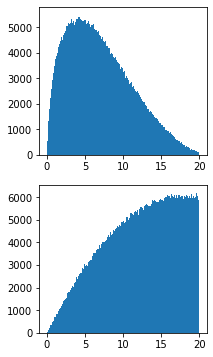

In [19]:
E = 0.5 * (np.linalg.norm(vel_halo_inert, axis=1))**2. + pot_halo
Lz = np.cross(pos_halo, vel_halo_inert)[:,2]
# plt.hist(E/1E6, bins=np.linspace(-0.3, 0.1, 1000))

R = np.linalg.norm(pos_halo[:,:2], axis=1)
fig, ax = plt.subplots(2, 1, figsize=(3, 6))

Ecut = -0.1 * 1E6

print(len(np.where(E<Ecut)[0]))

ax[0].hist(R[E<Ecut], bins=np.linspace(0, 20, 1000))
ax[1].hist(R[E>=Ecut], bins=np.linspace(0, 20, 1000))

plt.show()


In [16]:
Ecut = -0.2 * 1E6
pos_Ecut = pos_halo[E < Ecut]
vel_Ecut = vel_halo[E < Ecut]

E_Ecut = E[E<Ecut]
Lz_Ecut = Lz[E<Ecut]

In [ ]:
%%time
dt = 0.002
tmax = 20.0

x, v, t = integrate_orbit(dt, tmax, pos_Ecut[0:10000], vel_Ecut[0:10000], grav)

In [21]:
%%time
pos0 = pos_Ecut[0]
vel0 = vel_Ecut[0]
omega_phi= compute_phi_freq(pos0, vel0)
print(omega_phi)

a
(-24.06264150432099, 54.97708153722498)
CPU times: user 181 ms, sys: 836 µs, total: 182 ms
Wall time: 181 ms


In [22]:
print(len(E))

25347840


In [27]:
freq = np.array([compute_phi_freq(pos_Ecut[i], vel_Ecut[i]) for i in tqdm(range(4000))])

A Jupyter Widget

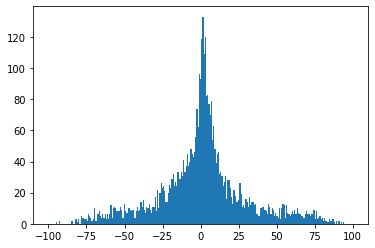

In [32]:
plt.hist(freq[:,0], bins=np.linspace(-100, 100, 256))
plt.show()

85


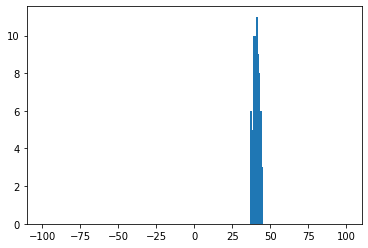

In [36]:
CR = np.abs(freq[:,0]/ps -1 ) < 0.1
print(len(np.where(CR)[0]))
plt.hist(freq[:,0][CR], bins=np.linspace(-100, 100, 256))
plt.show()

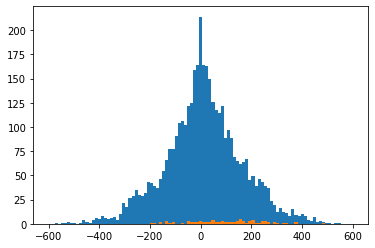

In [49]:
plt.hist(Lz_Ecut[:4000], bins=np.linspace(-600, 600, 100))
plt.hist(Lz_Ecut[:4000][CR], bins=np.linspace(-600, 600, 100))
plt.show()

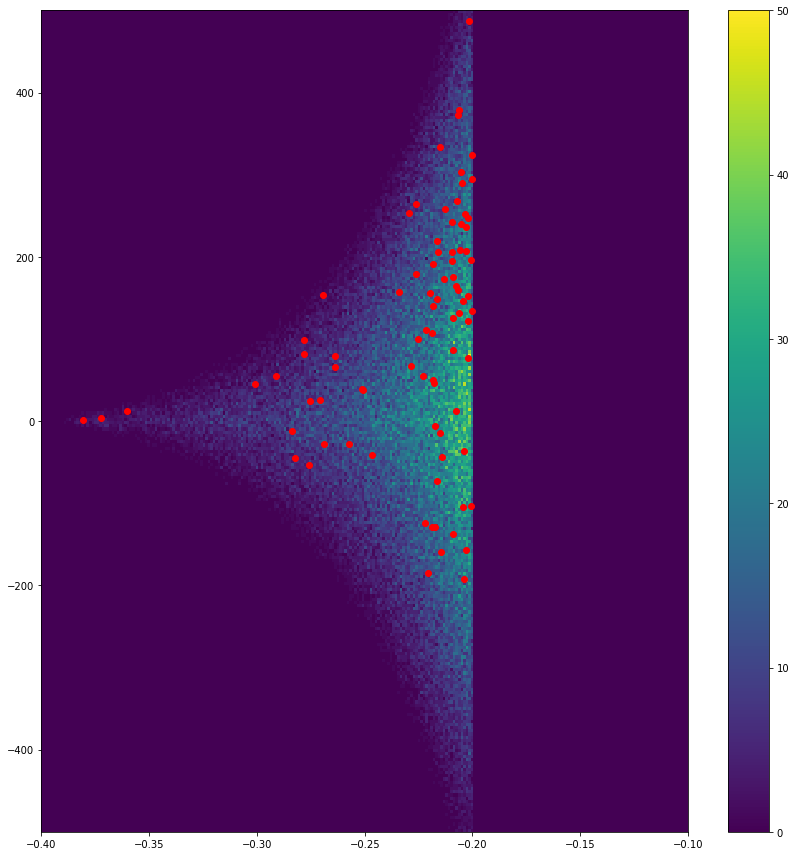

In [59]:
nres = 256

range_xy = [[-0.4, -0.1], [-500, 500]]

x = E_Ecut/1E6
y = Lz_Ecut
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

im = ax.imshow(heatmap_xy.T, extent=extent, origin='lower')#, vmin=-0.2, vmax=0.2)#, vmin=-50000, vmax=50000)
ax.set_aspect('auto')
fig.colorbar(im)

ax.scatter(E_Ecut[:4000][CR]/1E6, Lz_Ecut[:4000][CR], c='r')

fig.tight_layout()

plt.show()
